In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Data import and basic summary
np.random.seed(49)
DashData = pd.read_csv("C:/Users/Zach/Documents/GitHub/DoorDashModels/Data/historical_data.csv")
DashData.head(10)
DashData.info()
DashData.describe()
print("Percentange of missing value % :",DashData.isna().mean().mean()*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
#Creating the target variable for models
from datetime import datetime
DashData['created_at'] = pd.to_datetime(DashData['created_at'])
DashData["actual_delivery_time"] = pd.to_datetime(DashData["actual_delivery_time"])
DashData["Total_Delivery_Duration"] = (DashData["actual_delivery_time"] - DashData["created_at"]).dt.total_seconds()

DashData.head(10)
#New feature creations
DashData['Estimated_non_prep_duration'] = DashData["estimated_store_to_consumer_driving_duration"] + DashData["estimated_order_place_duration"]
DashData['BusyDriverRatio'] = DashData["total_busy_dashers"] / DashData["total_onshift_dashers"]
#Time features
DashData['Months'] = DashData['created_at'].dt.month
DashData['Quarter'] = DashData['created_at'].dt.quarter
#aggregate features
DashData['TotalOrderPerStore'] = DashData.groupby('store_id')['total_items'].transform('sum')
DashData['OrderValuePerStore'] = DashData.groupby('store_id')['total_items'].transform('mean')
DashData['OrderCountMonthsPerStore'] = DashData.groupby('Months')['total_items'].transform('sum')

#simple store metrics
avg_by_category= DashData.groupby('store_primary_category')['subtotal'].mean() / 100
print("Average subtotals per store category in dollars:")
print(avg_by_category)
std_by_category = DashData.groupby('store_primary_category')['subtotal'].std() / 100
print("\nStandard deviation of subtotals per store category in dollars:")
print(std_by_category)
print("Average order delivery time in minutes:")
print(f"{DashData['Total_Delivery_Duration'].mean()/60:.2f}")

DashData.head()



Average subtotals per store category in dollars:
store_primary_category
afghan               29.850756
african              26.997000
alcohol              26.565957
alcohol-plus-food    16.990000
american             26.585065
                       ...    
thai                 31.080275
turkish              28.858565
vegan                25.098029
vegetarian           26.007349
vietnamese           22.585660
Name: subtotal, Length: 74, dtype: float64

Standard deviation of subtotals per store category in dollars:
store_primary_category
afghan               17.588114
african              11.044908
alcohol              17.889367
alcohol-plus-food          NaN
american             16.910146
                       ...    
thai                 18.538711
turkish              16.714752
vegan                15.727010
vegetarian           15.437324
vietnamese           15.615800
Name: subtotal, Length: 74, dtype: float64
Average order delivery time in minutes:
48.47


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,Total_Delivery_Duration,Estimated_non_prep_duration,BusyDriverRatio,Months,Quarter,TotalOrderPerStore,OrderValuePerStore,OrderCountMonthsPerStore
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,446,861.0,3779.0,1307.0,0.424242,2,1,4,4.000000,411075
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,446,690.0,4024.0,1136.0,2.000000,2,1,37,2.846154,411075
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,446,690.0,1781.0,1136.0,0.000000,1,1,37,2.846154,219981
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,446,289.0,3075.0,735.0,1.000000,2,1,37,2.846154,411075
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,446,650.0,2390.0,1096.0,1.000000,2,1,37,2.846154,411075


In [5]:
#creating a dictionary for store categories to fill the null categories using the most common category -- could be better way to do with with SME
store_id_unique = DashData["store_id"].unique().tolist()
store_id_and_category = {store_id: DashData[DashData.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
DashData["nan_free_store_primary_category"] = DashData.store_id.apply(fill)


In [6]:
#creating dummies
OrderProtocalDummies =pd.get_dummies(DashData.order_protocol, dtype=int)
OrderProtocalDummies = OrderProtocalDummies.add_prefix('OrderProtocal_')
#checking
OrderProtocalDummies.head()
MarketIdDummies = pd.get_dummies(DashData.market_id, dtype=int)
MarketIdDummies = MarketIdDummies.add_prefix('MarketId_')
#checking
MarketIdDummies.head()
StoreCategoryDummies = pd.get_dummies(DashData.nan_free_store_primary_category, dtype=int)
StoreCategoryDummies = StoreCategoryDummies.add_prefix('StoreCategory_')
#checking
StoreCategoryDummies.head()

,StoreCategory_afghan,StoreCategory_african,StoreCategory_alcohol,StoreCategory_alcohol-plus-food,StoreCategory_american,StoreCategory_argentine,StoreCategory_asian,StoreCategory_barbecue,StoreCategory_belgian,StoreCategory_brazilian,...,StoreCategory_southern,StoreCategory_spanish,StoreCategory_steak,StoreCategory_sushi,StoreCategory_tapas,StoreCategory_thai,StoreCategory_turkish,StoreCategory_vegan,StoreCategory_vegetarian,StoreCategory_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# defining the intial train DF
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df.head()
#merging the dummies to train
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
#checking
train_df.head()
#seeing which fetures that have infinte max value -- could be issue for models
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")
#ensuring dtype synergy
train_df = train_df.astype("Float32")

Features with infinite max value:
Index(['BusyDriverRatio'], dtype='object')


In [8]:
#replacing infinite values in BusyDriverRatio with NaN then with the mean of the column
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].replace([np.inf, -np.inf], np.nan)
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].fillna(train_df["BusyDriverRatio"].mean())
#checking
train_df["BusyDriverRatio"].describe()


count    197428.0
mean     0.949777
std      0.385194
min         -13.0
25%      0.846154
50%      0.949778
75%           1.0
max          31.0
Name: BusyDriverRatio, dtype: Float64

<Axes: >

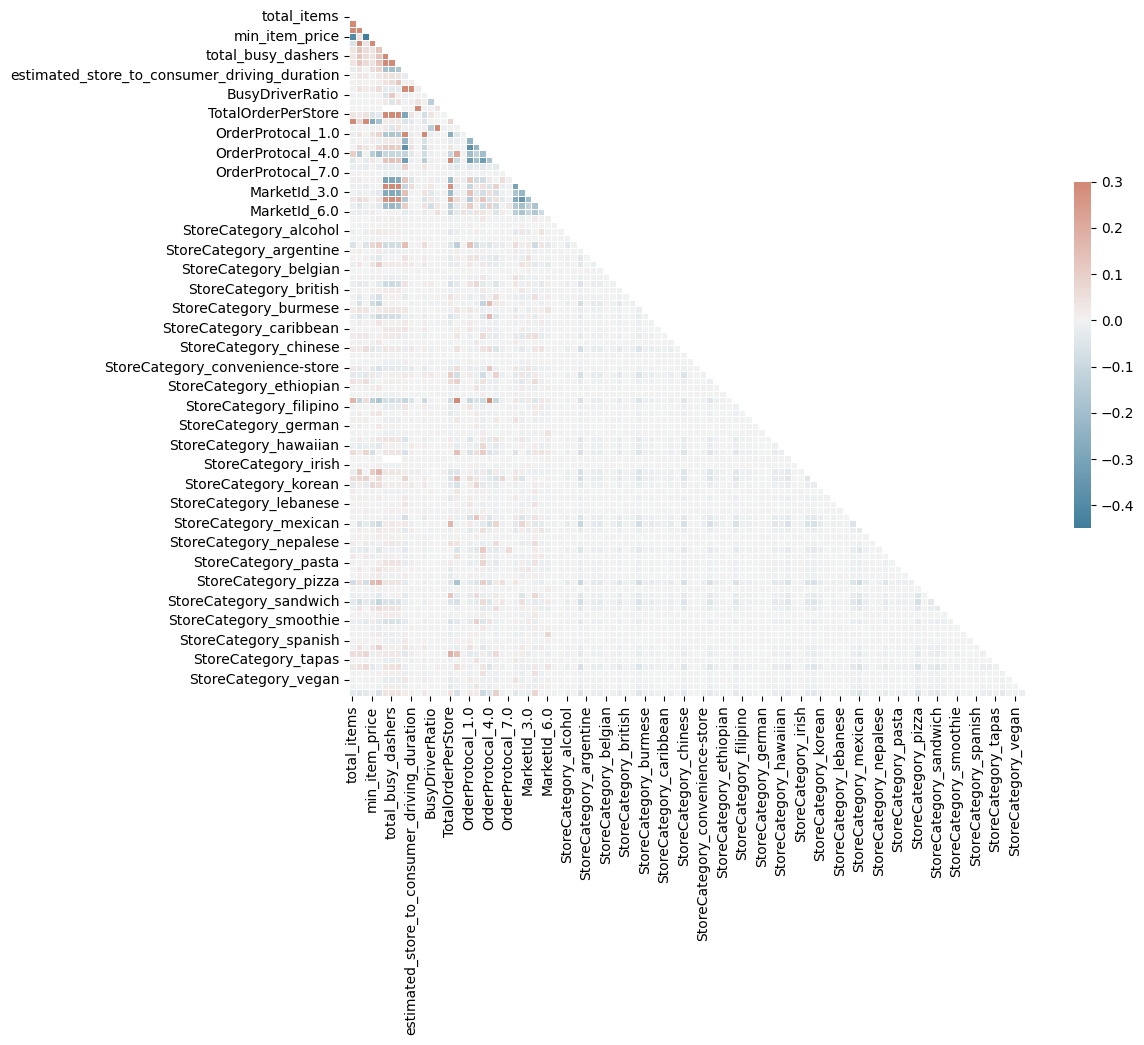

In [9]:
#Next Task (3/20): Removing Redundant and Potential Collinear Features to prepare for FAMD analysis
corrMatrix = train_df.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [10]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sorting correlations in the descending order and return n highest results"""
    AB_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    AB_corr = AB_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return AB_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 15))
#removing the features
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers","StoreCategory_indonesian",])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)


Top Absolute Correlations

Months                                        OrderCountMonthsPerStore       0.998849
Total_Delivery_Duration                       Quarter                        0.996475
total_onshift_dashers                         total_busy_dashers             0.943789
                                              total_outstanding_orders       0.936122
total_busy_dashers                            total_outstanding_orders       0.932913
estimated_store_to_consumer_driving_duration  Estimated_non_prep_duration    0.923613
estimated_order_place_duration                OrderProtocal_1.0              0.895608
total_items                                   num_distinct_items             0.763912
subtotal                                      num_distinct_items             0.681101
total_items                                   subtotal                       0.558067
min_item_price                                max_item_price                 0.545484
subtotal                   

In [11]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))
#removing highly correlated features -- could be better with consulting SME for feature importance in dataset
train_df = train_df.drop(columns=["Months", "estimated_order_place_duration","Estimated_non_prep_duration",])


Top Absolute Correlations

Months                                        OrderCountMonthsPerStore       1.000000
estimated_store_to_consumer_driving_duration  Estimated_non_prep_duration    0.923086
estimated_order_place_duration                OrderProtocal_1.0              0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
OrderProtocal_4.0                             StoreCategory_fast             0.489946
num_distinct_items                            min_item_price                 0.446733
total_items                                   OrderValuePerStore             0.438134
MarketId_2.0               

In [12]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))

Top Absolute Correlations

total_items               num_distinct_items    0.758146
subtotal                  num_distinct_items    0.682890
total_items               subtotal              0.557175
min_item_price            max_item_price        0.541241
subtotal                  max_item_price        0.507947
OrderProtocal_4.0         StoreCategory_fast    0.489946
num_distinct_items        min_item_price        0.446733
total_items               OrderValuePerStore    0.438134
MarketId_2.0              MarketId_4.0          0.402421
OrderValuePerStore        StoreCategory_fast    0.390871
total_items               min_item_price        0.389277
OrderProtocal_1.0         OrderProtocal_3.0     0.373581
                          OrderProtocal_5.0     0.342345
TotalOrderPerStore        OrderProtocal_5.0     0.341527
num_distinct_items        OrderValuePerStore    0.340753
MarketId_1.0              MarketId_2.0          0.334580
OrderProtocal_3.0         OrderProtocal_5.0     0.332533
tota

In [13]:
# Still some features that are highly correlated --  creating some new features to replace the old ones
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["num_distinct_items", "subtotal","max_item_price", "min_item_price","OrderCountMonthsPerStore"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
OrderProtocal_4.0         StoreCategory_fast                0.489946
total_items               percent_distinct_item_of_total    0.445751
                          OrderValuePerStore                0.438134
MarketId_2.0              MarketId_4.0                      0.402421
OrderValuePerStore        StoreCategory_fast                0.390871
OrderProtocal_1.0         OrderProtocal_3.0                 0.373581
                          OrderProtocal_5.0                 0.342345
TotalOrderPerStore        OrderProtocal_5.0                 0.341527
MarketId_1.0              MarketId_2.0                      0.334580
total_items               price_range_of_items              0.333304
OrderProtocal_3.0         OrderProtocal_5.0                 0.332533
total_outstanding_orders  TotalOrderPerStore                0.323744
total_items               avg_price_per_item                0.310759
MarketId_1.0              MarketId_4.0                      0.302136
OrderVal

In [14]:
#Doing multicolinarity check using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function for VIF
def calculateVIF(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

#checking VIF

features = train_df.columns.to_list()
vif_data = calculateVIF(features)
vif_data



,feature,VIF
0,StoreCategory_alcohol-plus-food,1.001495
1,StoreCategory_chocolate,1.001533
2,StoreCategory_belgian,1.002850
3,BusyDriverRatio,1.014010
4,StoreCategory_russian,1.014028
...,...,...
92,OrderProtocal_3.0,51.221788
93,MarketId_4.0,51.444790
94,OrderProtocal_1.0,52.619584
95,MarketId_2.0,56.008435


In [15]:
#Wanting to drop the features with VIF > 20
features_to_drop = vif_data[vif_data["VIF"] > 20]["feature"].to_list()
features_to_drop
train_df.drop(columns=features_to_drop, inplace=True)
#checking the VIF again
features = train_df.columns.to_list()
vif_data = calculateVIF(features)
selected_features = vif_data['feature'].values.tolist()
vif_data

,feature,VIF
0,StoreCategory_alcohol-plus-food,1.000060
1,StoreCategory_belgian,1.000067
2,StoreCategory_chocolate,1.000106
3,StoreCategory_russian,1.000380
4,StoreCategory_gluten-free,1.000523
...,...,...
78,Total_Delivery_Duration,5.595276
79,BusyDriverRatio,6.038086
80,estimated_store_to_consumer_driving_duration,7.101782
81,OrderValuePerStore,12.538648


In [16]:

#checking to see if there are any infinite values
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")

No infinite values in the dataset


In [17]:
DashData["actual_delivery_time"] = pd.to_datetime(DashData["actual_delivery_time"])
train_df["actual_delivery_time"] = DashData["actual_delivery_time"]
#join with right dtype
train_df = train_df.drop(columns=["actual_delivery_time"]).astype("float32").join(train_df["actual_delivery_time"])

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#splitting the data
X = train_df[selected_features]
Y = train_df["actual_delivery_time"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)




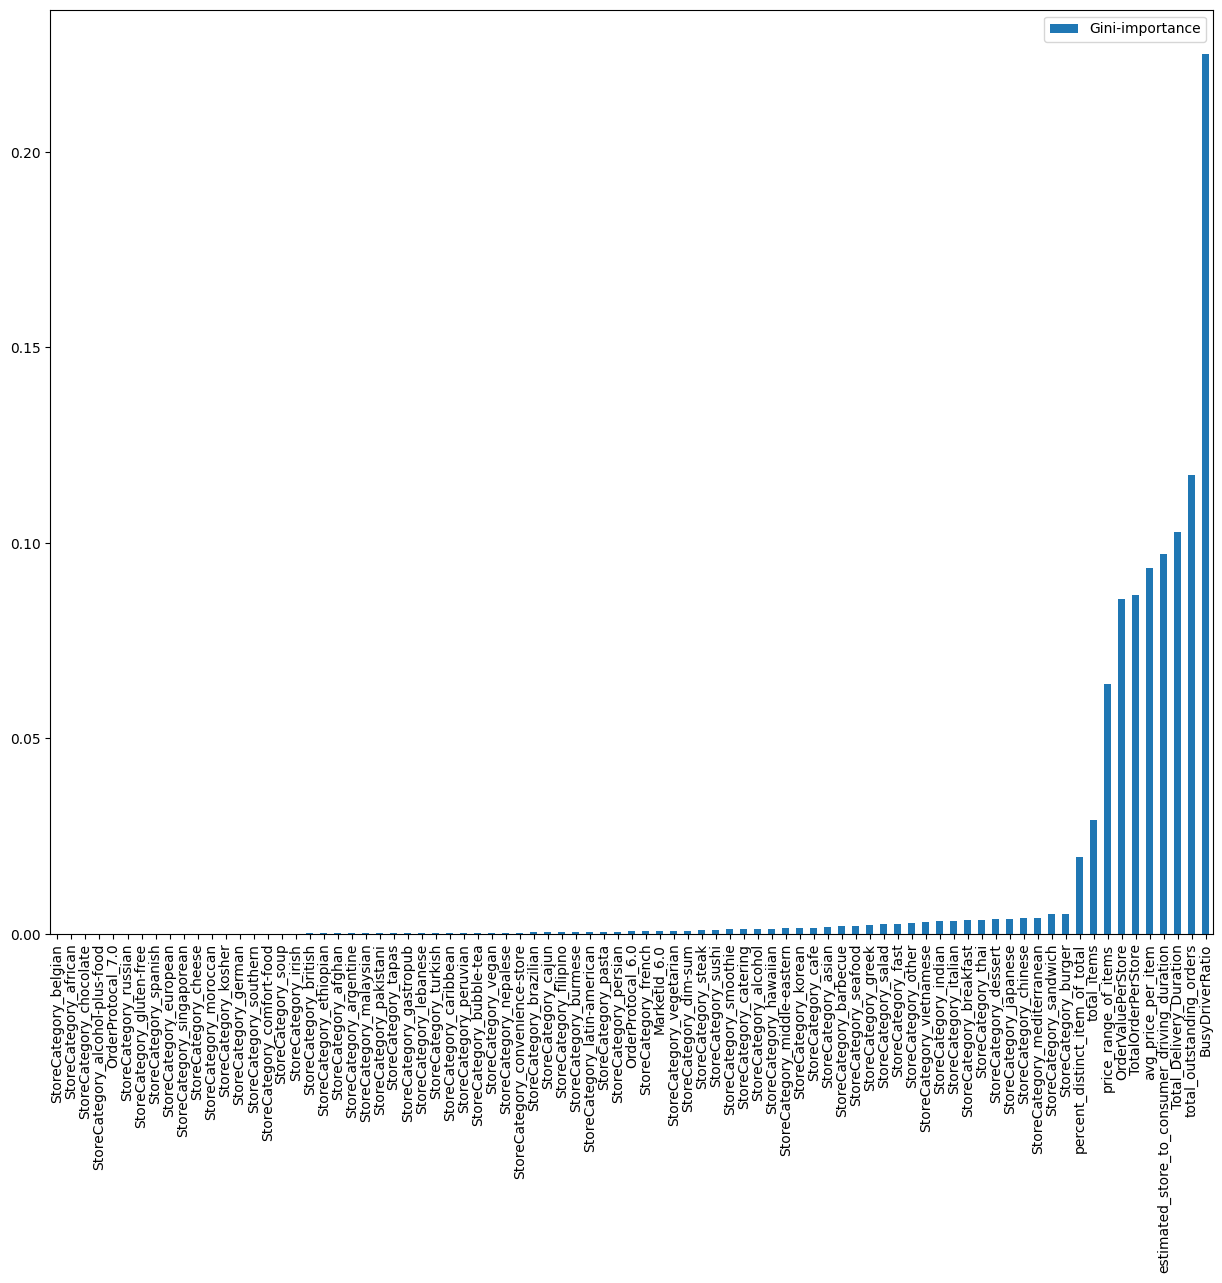

In [19]:
#plotting the feature importance
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, Y_train)
feats = {} 
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance  

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

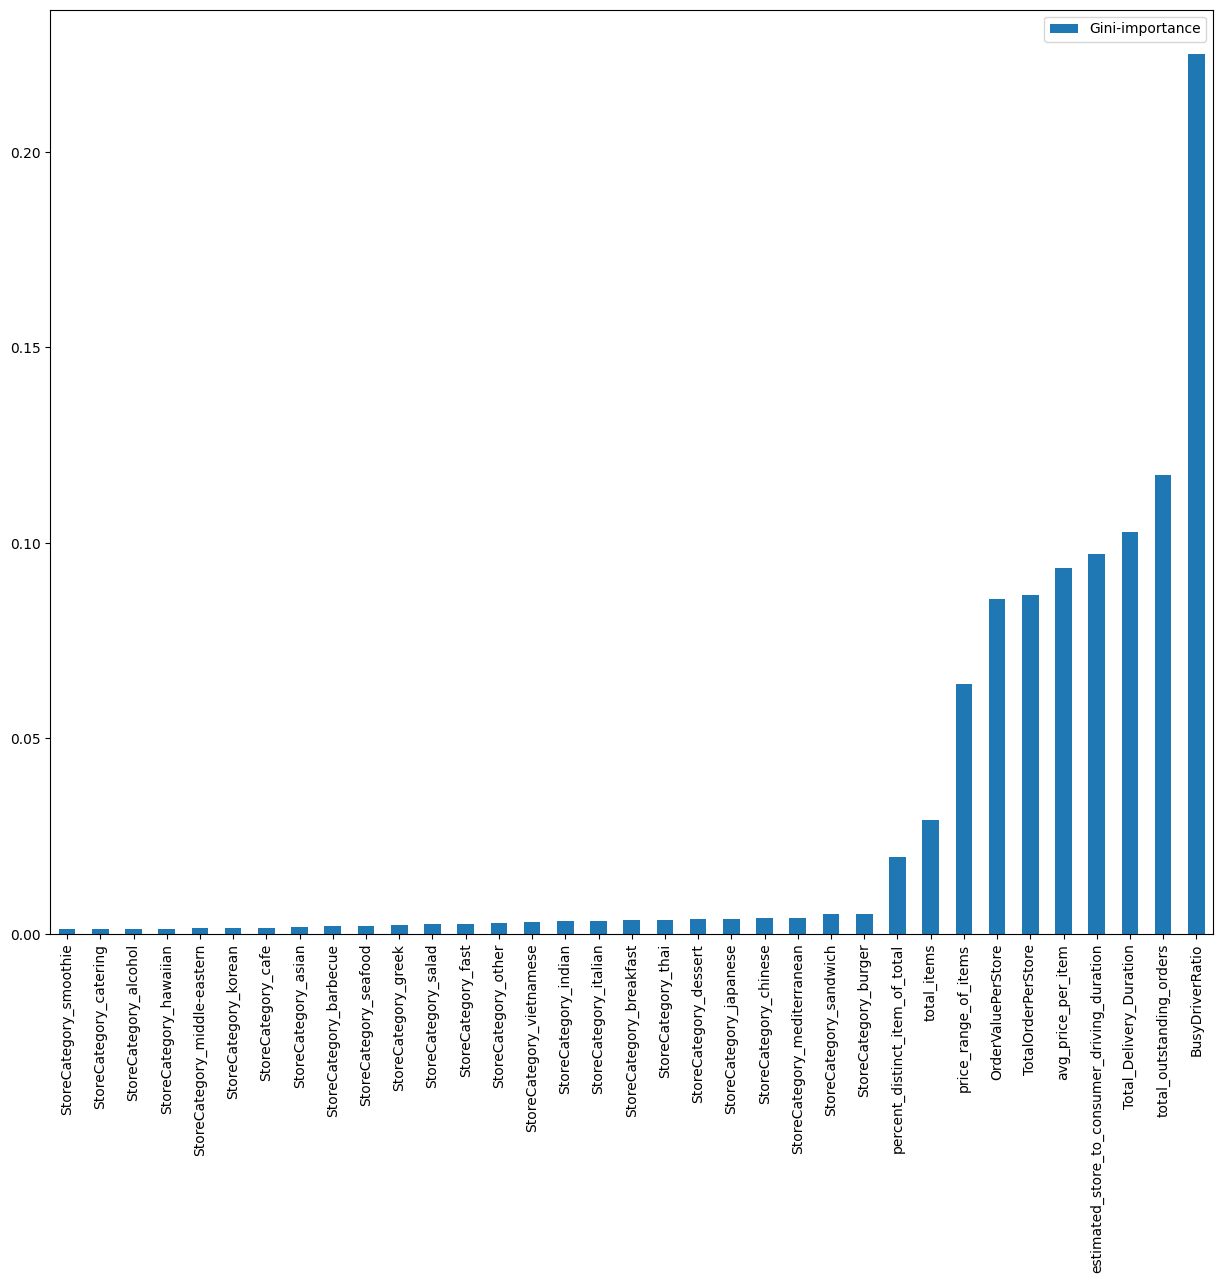

In [20]:
#checking the feature importance
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

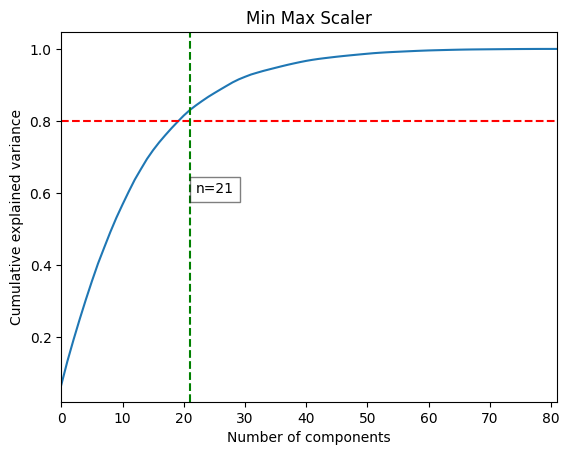

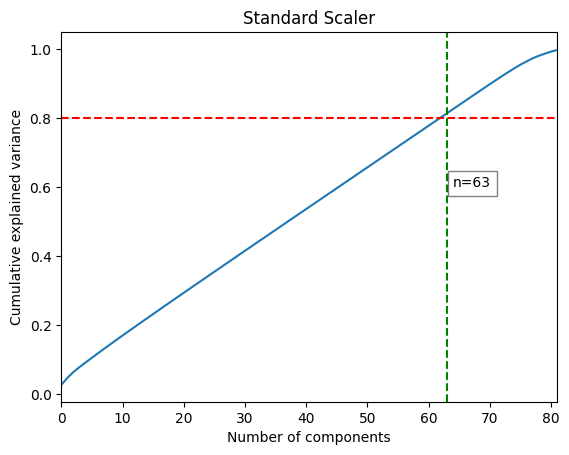

In [32]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Min Max Scaler
X_MinMaxScale=MinMaxScaler().fit_transform(X_Train)
pca = PCA().fit(X_MinMaxScale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Min Max Scaler")
plt.axhline(y=0.8, color='r', linestyle='--')
# Finding the number of components for 80% variance
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
plt.axvline(x=n_components_80, color='g', linestyle='--')
plt.text(n_components_80+1, 0.6, f'n={n_components_80}', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()



# Standard Scaler
X_stdScale=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_stdScale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Standard Scaler")
plt.axhline(y=0.8, color='r', linestyle='--')
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
plt.axvline(x=n_components_80, color='g', linestyle='--')
plt.text(n_components_80+1, 0.6, f'n={n_components_80}', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()

##PCA shows that around 60-70 components are needed to explain ~80% of the variance in the data which makes the PCA not very useful in this case

# 3/25/25 Update: Using MinMax Scaler allowed for the PCA to be more useful in this case causing around 18-20 components to explain ~80% of the variance in the data 


In [45]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the scaler to features and target variables using separate scaler instances."""
    X_scaler = scaler.__class__()  # create a new instance of the same scaler type
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = scaler.__class__()  # new instance for y
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    return X_scaled, y_scaled, X_scaler, y_scaler

In [46]:
#minmax scaler
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, Y)
# splitting after scaling 
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

In [47]:
#Inverse Transform for Metric comparison
# Since the data is scaled, need to apply the inverse transfrom to get the target variable measured in seconds and use RMSE to evaluate the errors
from sklearn.metrics import root_mean_squared_error
def RMSEInverse (scaler, y_test,y_pred_scaled, model_name):
    """Converting the scaled error to original error units """
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    #returning the RMSE
    rmse_error = root_mean_squared_error(y_test, y_predict[:,0])
    print(f"Error = {rmse_error} in {model_name}")
    return rmse_error, y_predict
    


In [48]:
#function to run the models:
def run_model(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply the selected model and measure the error."""
    model.fit(X_train, y_train)
    
    # Predictions on the training set
    y_train_pred = model.predict(X_train)
    train_error = root_mean_squared_error(y_train, y_train_pred)
    
    # Predictions on the test set
    y_test_pred = model.predict(X_test)
    test_error = root_mean_squared_error(y_test, y_test_pred)
    
    if verbose:
        print("Train error = {} in {}".format(train_error, model_name))
        print("Test error = {} in {}".format(test_error, model_name))
    
    return model, y_train_pred, y_test_pred, train_error, test_error


In [51]:
#Defining the models
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree, linear_model 
#formatting
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}
#Modles
regression_models ={
    "Ridge": linear_model.Ridge(),
    "Decision Tree": tree.DecisionTreeRegressor(max_depth=8),
    "Random Forest": RandomForestRegressor(max_depth=8, random_state=42),
    "XGBoost": XGBRegressor(max_depth=8, random_state=42),
    "MLP": MLPRegressor(max_iter=1000, random_state=42),
}
#feature sets
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

}
#scaler type
scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}
# examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X_unscaled = train_df[feature_set]
                y_unscaled = train_df["Total_Delivery_Duration"] 
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y_unscaled, test_size=0.2, random_state=42)
                model, _, y_predict, train_error, test_error = run_model(X_train_unscaled, y_train_unscaled, X_test_unscaled, y_test_unscaled, regression_models[model_name], model_name, verbose=True)
                rmse_error = test_error
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], Y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                
                # Run the model once to get predictions
                model, _, y_predict_scaled, _, test_error = run_model(
                    X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], 
                    regression_models[model_name], model_name, verbose=False)
                rmse_error = test_error
            
            # Add the model metadata to the prediction dictionary
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            # Remove duplicate RMSE appends
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are full dataset

-----scaled with MinMax scaler-------- included columns are full dataset

-----scaled with NotScale-------- included columns are full dataset

Train error = 0.0007370365201495588 in Ridge
Test error = 0.001233574002981186 in Ridge


c:\Users\Zach\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.69216e-15): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 11.672245193211225 in Decision Tree
Test error = 1478.2794064194193 in Decision Tree
Train error = 18.212468315740736 in Random Forest
Test error = 1511.2731811426324 in Random Forest
Train error = 9.426669120788574 in XGBoost
Test error = 1755.875732421875 in XGBoost
Train error = 7.978382587432861 in MLP
Test error = 249.83473205566406 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

-----scaled with MinMax scaler-------- included columns are selected_features_40

-----scaled with NotScale-------- included columns are selected_features_40

Train error = 0.0007508354028686881 in Ridge
Test error = 0.0012426325120031834 in Ridge


c:\Users\Zach\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.57794e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 11.672245193211225 in Decision Tree
Test error = 1479.1294404259895 in Decision Tree
Train error = 19.51755386281758 in Random Forest
Test error = 1510.3881644490207 in Random Forest
Train error = 8.618220329284668 in XGBoost
Test error = 1753.4122314453125 in XGBoost
Train error = 276.6332092285156 in MLP
Test error = 391.2221374511719 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

-----scaled with MinMax scaler-------- included columns are selected_features_20

-----scaled with NotScale-------- included columns are selected_features_20

Train error = 0.0006493264809250832 in Ridge
Test error = 0.0010523347882553935 in Ridge


c:\Users\Zach\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.30428e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 11.672245193211225 in Decision Tree
Test error = 1478.4306163132628 in Decision Tree
Train error = 18.21044281513083 in Random Forest
Test error = 1519.4539418679315 in Random Forest
Train error = 8.182141304016113 in XGBoost
Test error = 1752.0794677734375 in XGBoost
Train error = 27.73360252380371 in MLP
Test error = 308.4189453125 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

-----scaled with MinMax scaler-------- included columns are selected_features_10

-----scaled with NotScale-------- included columns are selected_features_10

Train error = 0.0006306819850578904 in Ridge
Test error = 0.0010419636964797974 in Ridge


c:\Users\Zach\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.9439e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 11.672245193211225 in Decision Tree
Test error = 1478.7499131020886 in Decision Tree
Train error = 17.024805703059926 in Random Forest
Test error = 1516.920341096159 in Random Forest
Train error = 7.742668628692627 in XGBoost
Test error = 1755.799072265625 in XGBoost
Train error = 164.2313995361328 in MLP
Test error = 169.4659881591797 in MLP


In [52]:
#dataframe for results
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,0.551456
1,Decision Tree,full dataset,Standard scaler,0.524323
2,Random Forest,full dataset,Standard scaler,0.520763
3,XGBoost,full dataset,Standard scaler,0.512354
4,MLP,full dataset,Standard scaler,0.537562
5,Ridge,full dataset,MinMax scaler,0.151239
6,Decision Tree,full dataset,MinMax scaler,0.144012
7,Random Forest,full dataset,MinMax scaler,0.143020
8,XGBoost,full dataset,MinMax scaler,0.140709
9,MLP,full dataset,MinMax scaler,0.151446


In [ ]:
# The MinMax Scaler combined with the tree-like models seems to be the best overall but the low errors could be due to overfitting (need to check this with cross validation before making final model selection/ predictions)